<a href="https://colab.research.google.com/github/Owais-cmd/AIML-project-/blob/main/AIML_4_mohit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CELL 1 — SETUP**

In [7]:
# =============================================================
# CELL 1 — SETUP
# =============================================================

# Enable GPU status check
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Mount Google Drive FIRST (to avoid losing files)
from google.colab import drive
drive.mount('/content/drive')

# Create project directory (safe location)
import os
PROJECT_DIR = "/content/drive/MyDrive/AIML_4_Project"
os.makedirs(PROJECT_DIR, exist_ok=True)
print("Project directory:", PROJECT_DIR)

# Install required dependencies (ONLY ONCE)
!pip install -q tensorflow tensorflow-datasets


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directory: /content/drive/MyDrive/AIML_4_Project


# **CELL 2 — MIXED PRECISION (faster GPU training)**

In [9]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")
print("Mixed precision enabled.")


Mixed precision enabled.


# **CELL 3 — LOAD STL-10 USING TFDS**

In [8]:
import tensorflow_datasets as tfds

ds_train, ds_test = tfds.load(
    "stl10",
    split=["train", "test"],
    as_supervised=False
)

print("TFDS STL-10 loaded successfully.")

TFDS STL-10 loaded successfully.


# **CELL 4 — DATA PIPELINE + NOISE GENERATION**

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (96, 96)
BATCH_SIZE = 64

def preprocess(x):
    image = tf.cast(x["image"], tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    return image

# Noise functions — PURE TF (FAST)
@tf.function
def gaussian_noise(img, std=0.1):
    noise = tf.random.normal(tf.shape(img), 0, std)
    return tf.clip_by_value(img + noise, 0, 1)

@tf.function
def salt_pepper(img, amount=0.02):
    rnd = tf.random.uniform(tf.shape(img))
    img = tf.where(rnd < amount/2, 1.0, img)
    img = tf.where((rnd >= amount/2) & (rnd < amount), 0.0, img)
    return img

@tf.function
def random_noise(img):
    r = tf.random.uniform([])
    return tf.cond(r < 0.5,
                   lambda: gaussian_noise(img),
                   lambda: salt_pepper(img))

def to_noisy_pair(img):
    noisy = random_noise(img)
    return noisy, img

# Build pipelines
train_pipeline = (
    ds_train.map(preprocess, AUTOTUNE)
            .cache()
            .shuffle(5000)
            .map(to_noisy_pair, AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

val_pipeline = (
    ds_test.map(preprocess, AUTOTUNE)
           .map(to_noisy_pair, AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE)
)

print("Data pipeline ready.")


Data pipeline ready.


# **CELL 5 — U-NET DENOISER (MODERN IMPLEMENTATION)**

In [11]:
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    s = conv_block(x, filters)
    p = layers.MaxPool2D()(s)
    return s, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(96,96,3), base=32):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, base)
    s2, p2 = encoder_block(p1, base*2)
    s3, p3 = encoder_block(p2, base*4)

    b = conv_block(p3, base*8)
    b = conv_block(b, base*8)

    d3 = decoder_block(b, s3, base*4)
    d2 = decoder_block(d3, s2, base*2)
    d1 = decoder_block(d2, s1, base)

    outputs = layers.Conv2D(3, 1, activation="sigmoid")(d1)
    return Model(inputs, outputs)

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 96,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │    590,080 │ activation_3[0][

 Total params: 1,757,027 (6.70 MB)

 Trainable params: 1,755,107 (6.70 MB)

 Non-trainable params: 1,920 (7.50 KB)

# **CELL 6 — COMPILE + CALLBACKS**

In [12]:
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
)

SAVE_DIR = f"{PROJECT_DIR}/models"
os.makedirs(SAVE_DIR, exist_ok=True)

checkpoint_path = f"{SAVE_DIR}/best_model.keras"

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, verbose=1),
    CSVLogger(f"{SAVE_DIR}/training_log.csv")
]

print("Model compiled & callbacks ready.")


Model compiled & callbacks ready.


# **CELL 7 — TRAIN MODEL**

In [13]:
EPOCHS = 30

history = model.fit(
    train_pipeline,
    validation_data=val_pipeline,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.0228
Epoch 1: val_loss improved from inf to 0.04749, saving model to /content/drive/MyDrive/AIML_4_Project/models/best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 428ms/step - loss: 0.0227 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 2/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0033
Epoch 2: val_loss improved from 0.04749 to 0.03763, saving model to /content/drive/MyDrive/AIML_4_Project/models/best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 0.0033 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 3/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0028
Epoch 3: val_loss improved from 0.03763 to 0.02533, saving model to /content/drive/MyDrive/AIML_4_Project/models/best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.0027 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0026
Epoch 4: val_loss improved from 0.02533 to 0.0126

# **CELL 8 — PLOT TRAINING LOSS**

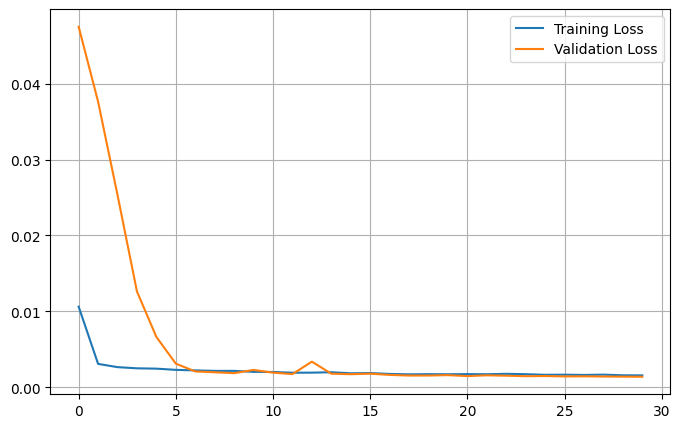

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{SAVE_DIR}/loss_plot.png")
plt.show()

# **CELL 9 — VISUALIZE RESULTS**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


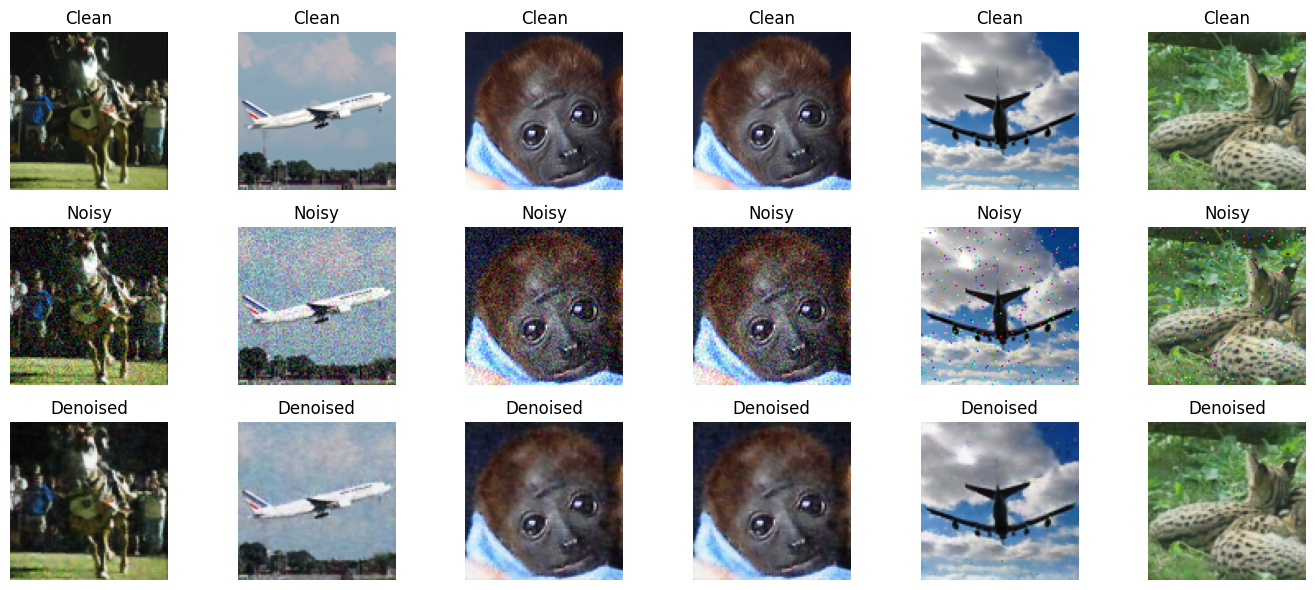

In [16]:
# === FIXED CELL 9: convert float16 -> float32 for plotting ===
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from val_pipeline (tf.Tensors)
noisy_batch, clean_batch = next(iter(val_pipeline))

# Make predictions (may be float16 if mixed precision is enabled)
preds = model.predict(noisy_batch)

# Convert to numpy and ensure dtype is float32 and values are in [0,1]
def to_np_float32(x):
    # handles tf.Tensor or numpy arrays (float16 -> float32)
    if hasattr(x, "numpy"):
        arr = x.numpy()
    else:
        arr = np.array(x)
    return arr.astype(np.float32)

noisy_np = to_np_float32(noisy_batch)
clean_np = to_np_float32(clean_batch)
preds_np  = to_np_float32(preds)

# Clip values to [0,1] just in case
noisy_np = np.clip(noisy_np, 0.0, 1.0)
clean_np = np.clip(clean_np, 0.0, 1.0)
preds_np  = np.clip(preds_np, 0.0, 1.0)

# Plot & save
plt.figure(figsize=(14,6))
for i in range(6):
    idx = np.random.randint(0, noisy_np.shape[0])

    plt.subplot(3, 6, i+1)
    plt.imshow(clean_np[idx])          # now float32 -> ok
    plt.title("Clean")
    plt.axis("off")

    plt.subplot(3, 6, 6+i+1)
    plt.imshow(noisy_np[idx])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(3, 6, 12+i+1)
    plt.imshow(preds_np[idx])
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/sample_results.png", bbox_inches="tight")
plt.show()


# **CELL 10 — SAVE FINAL MODEL SAFELY**

In [17]:
model.save(f"{SAVE_DIR}/final_unet_denoiser.keras")
print("Final model saved to:", SAVE_DIR)

Final model saved to: /content/drive/MyDrive/AIML_4_Project/models


below things were just certain measure i took

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
PROJECT_DIR = "/content/drive/MyDrive/AIML_4_Project"
os.makedirs(PROJECT_DIR, exist_ok=True)
PROJECT_DIR


'/content/drive/MyDrive/AIML_4_Project'

In [4]:
!pip install tensorflow tensorflow-datasets


In [6]:
import tensorflow_datasets as tfds
ds_train, ds_test = tfds.load("stl10", split=["train", "test"], with_info=False)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.R2LDI4_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.R2LDI4_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.R2LDI4_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.
